# CIFAR3 Calibration Benchmark

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary
from calibrators import NiceCalibrator, PlanarFlowCalibrator, RadialFlowCalibrator, RealNvpCalibrator, TempScalingCalibrator 

In [4]:
%matplotlib inline
np.random.seed(1)

In [5]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

In [6]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

## Calibrating NICE
Select number of flow stages:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fitted in 74.176s
Fitted in 106.453s
Fitted in 137.362s


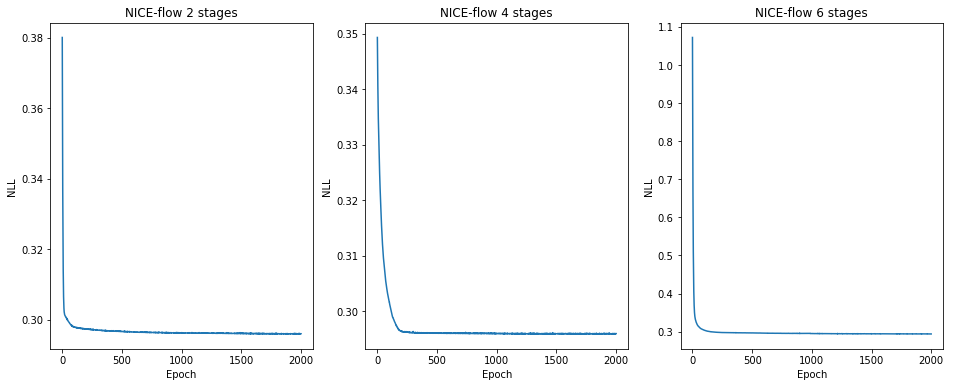

In [7]:
t0 = time.time()
nice_cal_2 = NiceCalibrator(val_logits, val_target, layers=2, hidden_size=[1],
                            version=2, epochs=2000)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal_4 = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[1],
                            version=2, epochs=2000)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal_6 = NiceCalibrator(val_logits, val_target, layers=6, hidden_size=[1],
                            version=2, epochs=2000)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
fig, ax_arr = plt.subplots(1, 3, figsize=(16, 6))

ax_arr[0].plot(nice_cal_2.history.history['loss'])
ax_arr[0].set_title('NICE-flow 2 stages')
ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_xlabel('Epoch')

ax_arr[1].plot(nice_cal_4.history.history['loss'])
ax_arr[1].set_title('NICE-flow 4 stages')
ax_arr[1].set_ylabel('NLL')
ax_arr[1].set_xlabel('Epoch')

ax_arr[2].plot(nice_cal_6.history.history['loss'])
ax_arr[2].set_title('NICE-flow 6 stages')
ax_arr[2].set_ylabel('NLL')
ax_arr[2].set_xlabel('Epoch')

plt.show()